# Moloco Regression Question

To build a good regression model, generally we start from the linear regression model. Here I use the stochastic gradient dscent algorithm.

In [1]:
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

Import csv data. Here I find an outlier, C value equals to -10000, so we first delete this point.

In [2]:
df = pd.read_csv("regression.csv", header = None)
data = df.values.tolist()
for rows in data:
    if rows[2] <= -10000.0:
        data.remove(rows)

Normalize dataset function

In [3]:
def dataset_minmax(dataset):
    minmax = []
    for i in range(3):
        col_values = [row[i] for row in dataset]
        # print(col_values)
        value_min = min(col_values)
        # print(value_min)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax
 
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(3):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

cross validation split function

In [4]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = []
    dataset_copy = dataset.copy()
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = []
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

Cost evaluation function.

In [5]:
# Calculate root mean squared error
def rmse_metric(actual, predicted):
    sum_error = 0.0
    for i in range(len(actual)):
        prediction_error = predicted[i] - actual[i]
        sum_error += (prediction_error ** 2)
    mean_error = sum_error / float(len(actual))
    return math.sqrt(mean_error)
 
# Evaluation
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = []
    coef = []
    for fold in folds:
        train_set = folds.copy()
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = []
        for row in fold:
            row_copy = row.copy()
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted, coefficient = algorithm(train_set, test_set, *args)
        coef.append(coefficient)
        actual = [row[-1] for row in fold]
        rmse = rmse_metric(actual, predicted)
        scores.append(rmse)
    return scores, coef

Make a prediction with the model coefficients

In [6]:
def predict(row, coefficients):
    y_predict = coefficients[0]
    for i in range(len(row)-1):
        y_predict += coefficients[i + 1] * row[i]
    return y_predict

Stochastic Gradient Descent to calculate coefficients.

In [7]:
def coefficients_sgd(train, l_rate, n_epoch):
    coef = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
            y_predict = predict(row, coef)
            error = y_predict - row[-1]
            coef[0] = coef[0] - l_rate * error
            for i in range(len(row)-1):
                coef[i + 1] = coef[i + 1] - l_rate * error * row[i]
                # print(l_rate, n_epoch, error)
    return coef
def linear_regression_sgd(train, test, l_rate, n_epoch):
    predictions = []
    coefficients = []
    coef = coefficients_sgd(train, l_rate, n_epoch)
    coefficients.append(coef)
    for row in test:
        y_predicted = predict(row, coef)
        predictions.append(y_predicted)
    return predictions, coefficients

In [8]:
# normalization
minmax = dataset_minmax(data)
normalize_dataset(data, minmax)
print(minmax)

[[-8.86, 20.6], [-2.89, 7.0], [-315.0, 202.0]]


In [9]:
# print(data)
# evaluate algorithm
n_folds = 5
l_rate = 0.01
n_epoch = 50
scores, coefficient = evaluate_algorithm(data, linear_regression_sgd, n_folds, l_rate, n_epoch)
print('Scores: %s' % scores)
print('Coefficient: %s' % coefficient)
print('Mean RMSE: %.3f' % (sum(scores)/float(len(scores))))

Scores: [0.1242385471777202, 0.0971492083477533, 0.08876805529806155, 0.1401804374346652, 0.0904091110271743]
Coefficient: [[[0.746602115177666, -0.03228572405680656, -0.2780457511642585]], [[0.768601760547494, -0.06112109585489226, -0.3011681015944276]], [[0.7882189359071149, -0.11919973027214283, -0.298802954279897]], [[0.7415221073046586, -0.04191009703671416, -0.2527844092985433]], [[0.7715072220009079, -0.0728208513814503, -0.3008458385555848]]]
Mean RMSE: 0.108


We choose the lowest scores --- the third one and the corresponding coefficient is [0.7690629822110212, -0.06494108067507023, -0.3096381403476266]. Then we draw the predicted Y_predict and actul Y_actul. The red dot is the predict value and the blue dot is the actual value.

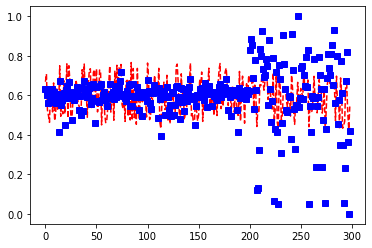

In [10]:
coefficients = coefficient[2][0]
y_predict = []
y_actul = []
for row in data:
    y_p = coefficients[0]
    y_actul.append(row[2])
    for i in range(2):
        y_p += coefficients[i + 1] * row[i]
    y_predict.append(y_p)
x = list(range(len(data)))
plt.plot(x, y_predict, 'r--', x, y_actul, 'bs')

From the picture, I find that the linear regression is not the best fit for this dataset. Most of those y value is predicted well while for the larger y value, the model does not fit well. While think of nonlinear regression, the neural network could be better used here.
For the current model, the function is (after normalization):
y = 0.77 - 0.065 * x1 - 0.310 * x2
For the current model, the function is (before normalization):
y = 25.73 - 1.14 * x1 - 16.19 * x2